In [125]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageColor
import IPython.display as Ipd
import subprocess

import torch

import sys
sys.path.insert(1, '../data/')
sys.path.insert(1, '../models/')

import image_utils
import model_helper

In [116]:
def print_img(img_path):
    Ipd.display(Ipd.Image(img_path))

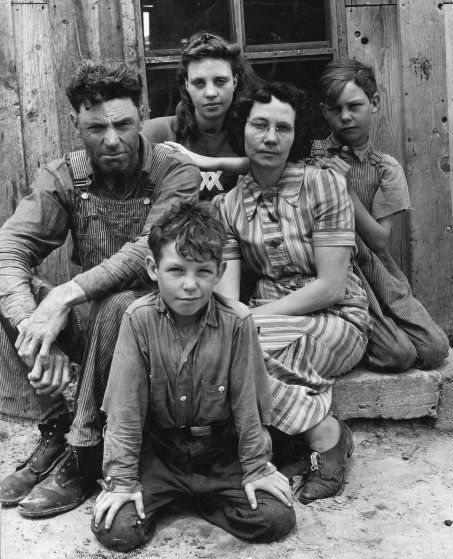

In [117]:
# Load Data
img_path = '../test_img/img/0.jpg'

print_img(img_path)

In [118]:
# Inference Box
tmp = subprocess.call('../inference_box/infer_box_for_test.sh', shell=True)

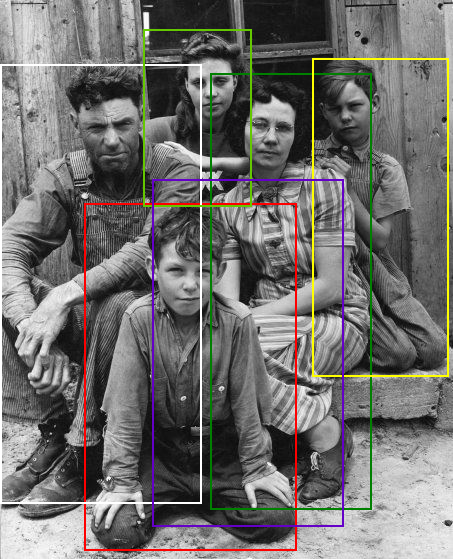

In [134]:
# Read Inference Box
box_path = '../test_img/img_bbox/0.npz'
box_list = image_utils.get_bbx_fusion(box_path)

with Image.open(img_path).convert("RGB") as im:
    draw = ImageDraw.Draw(im)
    
    colors = ['red','green','yellow','white', 'rgb(100, 200, 0)', 'rgb(100, 0, 200)',
              'rgb(0, 100, 200)', 'rgb(150, 50, 0)']

    for i in range(len(box_list)):
        draw.rectangle([box_list[i][0], box_list[i][1],
                        box_list[i][2], box_list[i][3]], outline=colors[i%8], width=2)

    im.show()

In [135]:
# Load Model

model_name = 'F_pretrained_on_small'

model, _ = model_helper.get_model(model_name)
model = model.cuda()

# Prepare data
inputs, targets = image_utils.out_fusion_train_data(img_path, box_path)
inputs = [inputs[0].cuda().unsqueeze(dim=0),
          inputs[1].cuda().unsqueeze(dim=0),
          {key:item.unsqueeze(dim=0) for key, item in inputs[2].items()}]
targets = targets.cuda()


In [136]:
def print_output(gray_channel, ab_channel):
    tmp_res_path = '../test_img/results/'
    gray_path = tmp_res_path + 'g.jpg'
    color_path = tmp_res_path + 'c.jpg'
    
    t1 = torch.zeros_like(gray_channel)
    t2 = torch.zeros_like(gray_channel)
    gray_img = torch.cat((gray_channel, t1, t2), dim=0)
    color_img = torch.cat((gray_channel, ab_channel), dim=0)
    image_utils.save_image_from_tensor(gray_path, gray_img.cpu())
    image_utils.save_image_from_tensor(color_path, color_img.cpu())

    fig, axs = plt.subplots(1, 2)
    gray_mat = Image.open(gray_path)
    axs[0].imshow(gray_mat)
    color_mat = Image.open(color_path)
    axs[1].imshow(color_mat)
    plt.show()

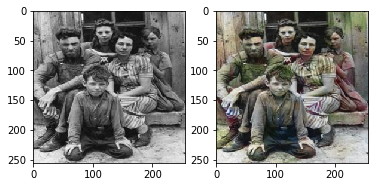

In [137]:
# Full image results
model.set_no_fusion(True)

outputs = model(inputs)
print_output(inputs[0][0], outputs[0])

model.set_no_fusion(False)

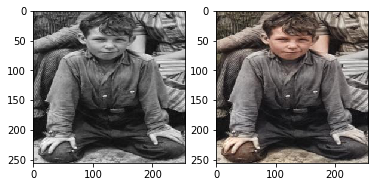

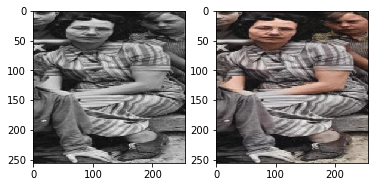

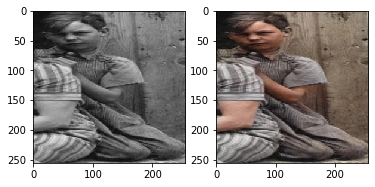

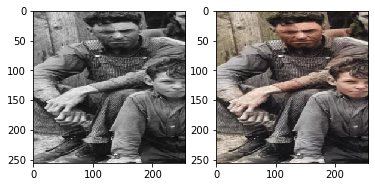

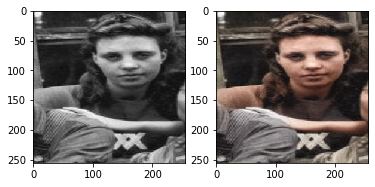

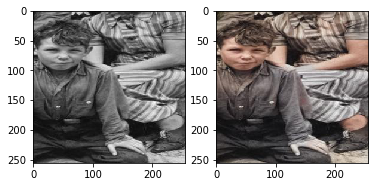

In [138]:
# Instances Results
outputs = model.instance_outputs(inputs)

for i in range(len(outputs)):
    print_output(inputs[1][0, i: i+1, :, :], outputs[i])

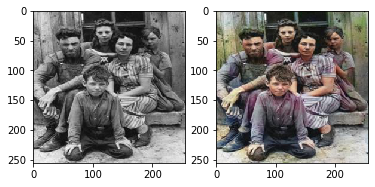

In [139]:
# Fusion results
outputs = model(inputs)
print_output(inputs[0][0], outputs[0])

In [63]:
# Thank you !